In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import LeavePOut
import plotly.express as px
from sklearn.metrics import mean_squared_error

In [3]:
CBF_TRAIN = pd.read_csv("CBF/CBF_TRAIN.txt",delim_whitespace=True,header=None)
CBF_TRAIN.columns = ["class"] + [i for i in np.arange(1,129)]

### 1D Fused Lasso

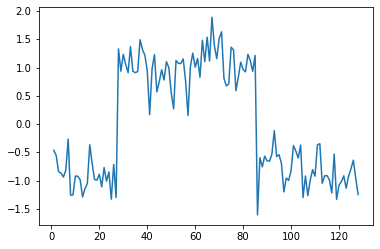

In [5]:
## example ts

CBF_TRAIN.iloc[0,1:].plot()
plt.show()

In [11]:
import cvxpy as cp
import scipy as scipy
import cvxopt as cvxopt
from copy import deepcopy
y = CBF_TRAIN.iloc[10,1:].values

In [12]:
def fused_lasso(ts,vlambda):
    n = ts.size
    x = cp.Variable(shape=n)
    obj = cp.Minimize(0.5 * cp.sum_squares(ts - x)
                      + vlambda * cp.sum(cp.abs(x[1:] - x[:-1])) )
    prob = cp.Problem(obj)
    prob.solve(solver=cp.CVXOPT, verbose=False)
    if prob.status != cp.OPTIMAL:
        raise Exception("Solver did not converge!")
        
    return np.array(x.value)

In [8]:
def get_best_vlambda(ts,possible_vlambdas,k):
    distances = []
    for vlambda in possible_vlambdas:
        
        eval_set = ts[1::k]
        train_set =ts[::k]
        x = fused_lasso(ts = train_set,vlambda = vlambda)
        dist = np.linalg.norm(eval_set-x)
        distances.append(dist)

    return possible_vlambdas[np.argmin(distances)]

In [113]:

best_vlambdas = []
for i in np.arange(30):
    y = CBF_TRAIN.iloc[i,1:].values
    best_vlambda = get_best_vlambda(y,possible_vlambdas =[i for i in np.arange(0.1,1,0.01)] ,k=2)
    best_vlambdas.append(best_vlambda)

In [114]:
# best lambda values for each ts 
print(best_vlambdas)

[0.9899999999999995, 0.9899999999999995, 0.8799999999999996, 0.6599999999999997, 0.9799999999999995, 0.7199999999999996, 0.9899999999999995, 0.9899999999999995, 0.9899999999999995, 0.14999999999999997, 0.8199999999999996, 0.9899999999999995, 0.8399999999999996, 0.8699999999999996, 0.9899999999999995, 0.9899999999999995, 0.3799999999999999, 0.7899999999999996, 0.9899999999999995, 0.9899999999999995, 0.5999999999999998, 0.6399999999999997, 0.8499999999999996, 0.9899999999999995, 0.5499999999999998, 0.7799999999999997, 0.9099999999999996, 0.8499999999999996, 0.9899999999999995, 0.5699999999999997]


In [115]:
fused_lass_repr = []
for i in np.arange(30):
    y = CBF_TRAIN.iloc[i,1:].values
    x = fused_lasso(ts = y,vlambda = best_vlambdas[i])
    fused_lass_repr.append(x)

In [116]:
CBF_TRAIN_fused_repr = pd.DataFrame(np.stack(fused_lass_repr))

In [117]:
y = CBF_TRAIN.iloc[10,1:].values
y_fused = CBF_TRAIN_fused_repr.iloc[10,:].values

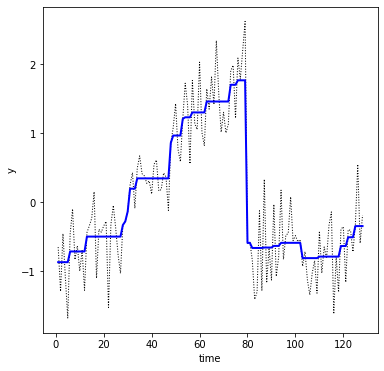

In [118]:
# Plot
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1,y.shape[0]+1), y, 'k:', linewidth=1.0)
plt.plot(np.arange(1,y.shape[0]+1), y_fused, 'b-', linewidth=2.0)
plt.xlabel('time')
plt.ylabel('y')
plt.show()

### Regression Tree

In [33]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

#### Sample 

In [40]:
y_sample = CBF_TRAIN.iloc[10,1:].reset_index()
y_sample.columns = ["t","y"]

In [41]:
reg = DecisionTreeRegressor(min_samples_split = 20, min_samples_leaf = 10, max_depth= 3,ccp_alpha=0)

In [42]:
dt = reg.fit(y_sample[["t"]],y_sample.y)

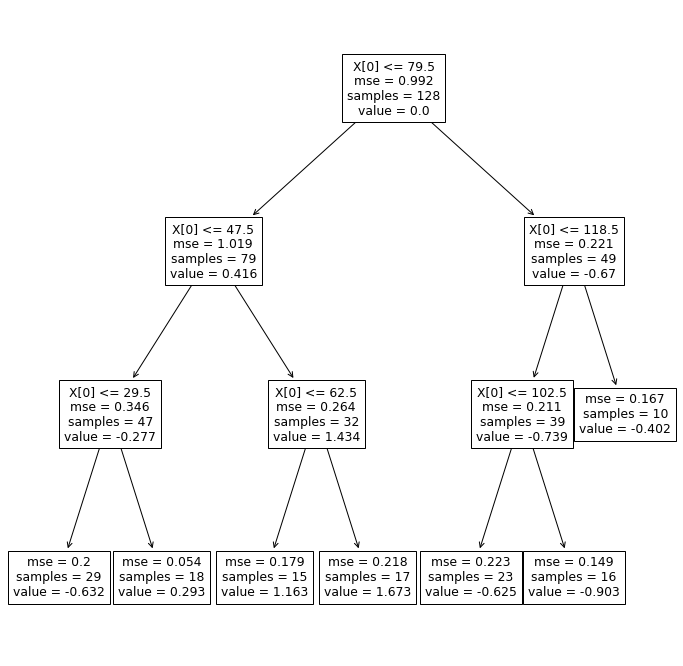

In [43]:
plt.figure(figsize=(12,12))
tree.plot_tree(reg)
plt.show()

In [44]:
y_reg = dt.predict(y_sample[["t"]])

/Users/yunus.karatas/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/yunus.karatas/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


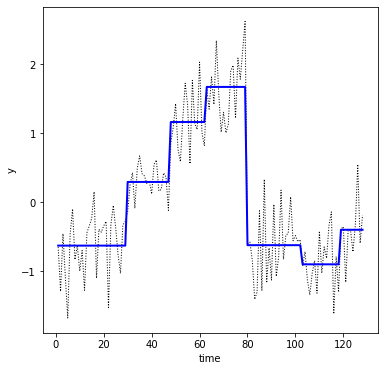

In [45]:
# Plot
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1,y_sample.shape[0]+1), y_sample.y, 'k:', linewidth=1.0)
plt.plot(np.arange(1,y_sample.shape[0]+1), y_reg, 'b-', linewidth=2.0)
plt.xlabel('time')
plt.ylabel('y')
plt.show()

#### Calculation for Each TS

In [68]:
def get_best_depth(ts,possible_depths,k):
    distances = []
    #possible_depths = [i for i in np.arange(2,15)]
    for depth in possible_depths:
        train_set =ts[::k]
        eval_set = ts[1::k]
        reg = DecisionTreeRegressor(min_samples_split = 20, min_samples_leaf = 10, max_depth= depth,ccp_alpha=0)
        dt = reg.fit(train_set[["t"]],train_set.y)
        eval_pred = dt.predict(eval_set[["t"]])
        dist = np.linalg.norm(eval_set.y.values-eval_pred)
        distances.append(dist)

    return possible_depths[np.argmin(distances)]

In [71]:
best_depths = []
for i in np.arange(30):
    y_sample = CBF_TRAIN.iloc[i,1:].reset_index()
    y_sample.columns = ["t","y"]
    best_depth = get_best_depth(y_sample,possible_depths =[i for i in np.arange(1,10,1)] ,k=2)
    best_depths.append(best_depth)

In [74]:
#best depth values for each time series
print(best_depths)

[2, 2, 2, 3, 4, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 4, 4, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2]


In [79]:
reg_tree_repr = []
for i in np.arange(30):
    y_sample =  CBF_TRAIN.iloc[i,1:].reset_index()
    y_sample.columns = ["t","y"]
    reg = DecisionTreeRegressor(min_samples_split = 20, min_samples_leaf = 10, max_depth= best_depths[i],ccp_alpha=0)
    pred = reg.fit(y_sample[["t"]],y_sample.y).predict(y_sample[["t"]])
    reg_tree_repr.append(pred)

In [80]:
CBF_TRAIN_reg_tree_repr = pd.DataFrame(np.stack(reg_tree_repr))

In [82]:
CBF_TRAIN_reg_tree_repr.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.90923,-0.90923,-0.90923,-0.90923,-0.90923,-0.90923,-0.90923,-0.90923,-0.90923,-0.90923,...,-0.94008,-0.94008,-0.94008,-0.94008,-0.94008,-0.94008,-0.94008,-0.94008,-0.94008,-0.94008
1,-1.16131,-1.16131,-1.16131,-1.16131,-1.16131,-1.16131,-1.16131,-1.16131,-1.16131,-1.16131,...,-1.11820,-1.11820,-1.11820,-1.11820,-1.11820,-1.11820,-1.11820,-1.11820,-1.11820,-1.11820
2,-0.63394,-0.63394,-0.63394,-0.63394,-0.63394,-0.63394,-0.63394,-0.63394,-0.63394,-0.63394,...,-0.65010,-0.65010,-0.65010,-0.65010,-0.65010,-0.65010,-0.65010,-0.65010,-0.65010,-0.65010
3,-0.64524,-0.64524,-0.64524,-0.64524,-0.64524,-0.64524,-0.64524,-0.64524,-0.64524,-0.64524,...,-0.43319,-0.43319,-0.43319,-0.43319,-0.43319,-0.43319,-0.43319,-0.43319,-0.43319,-0.43319
4,-0.91956,-0.91956,-0.91956,-0.91956,-0.91956,-0.91956,-0.91956,-0.91956,-0.91956,-0.91956,...,-1.20174,-1.20174,-1.20174,-1.20174,-1.20174,-1.20174,-1.20174,-1.20174,-1.20174,-1.20174


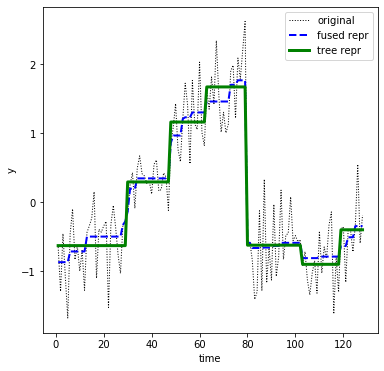

In [87]:
y = CBF_TRAIN.iloc[10,1:].values
y_fused = CBF_TRAIN_fused_repr.iloc[10,:].values
y_reg_tree = CBF_TRAIN_reg_tree_repr.iloc[10,:].values
# Plot
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1,y.shape[0]+1), y, 'k:', linewidth=1.0,label="original")
plt.plot(np.arange(1,y.shape[0]+1), y_fused, 'b--', linewidth=2.0,label="fused repr")
plt.plot(np.arange(1,y.shape[0]+1), y_reg_tree, 'g-', linewidth=3.0,label = "tree repr")
plt.xlabel('time')
plt.ylabel('y')
plt.legend()
plt.show()

### Computing MSE

In [89]:
y = CBF_TRAIN.iloc[10,1:].values
y_fused = CBF_TRAIN_fused_repr.iloc[10,:].values
y_reg_tree = CBF_TRAIN_reg_tree_repr.iloc[10,:].values

In [119]:
mse_fused = []
mse_reg = []
for i in np.arange(30):
    y = CBF_TRAIN.iloc[i,1:].values
    y_fused = CBF_TRAIN_fused_repr.iloc[i,:].values
    y_reg_tree = CBF_TRAIN_reg_tree_repr.iloc[i,:].values
    mse_fused.append(mean_squared_error(y,y_fused))
    mse_reg.append(mean_squared_error(y,y_reg_tree))

In [128]:
result_table = pd.DataFrame(zip(mse_fused,mse_reg),columns = ["1D Fused Lasso","Decision Tree"])

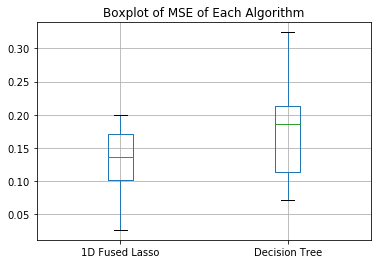

In [130]:
result_table.boxplot()
plt.title("Boxplot of MSE of Each Algorithm")
plt.show()


#### Comments

The boxplots show that 1D Fused Lasso is better than Decision Tree because the median MSE error of this algorithm is less than the Decision Tree. Complexity of 1D Fused Lasso model could be a reason for this outcome because it generates more piecewise line for each time series. It may overfit the data and thus prediction power of DT could be better.  

### 1-NN Classifier evaluation 

In [132]:
CBF_TEST = pd.read_csv("CBF/CBF_TEST.txt",delim_whitespace=True,header=None)
CBF_TEST.columns = ["class"] + [i for i in np.arange(1,129)]

In [136]:
test_sample = CBF_TEST.iloc[0,1:].values

In [149]:
from pyts.classification import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [140]:
CBF_TRAIN.head()

,class,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,1.00000,-0.46428,-0.55505,-0.84284,-0.86590,-0.93640,-0.81727,-0.26361,-1.25805,-1.25039,...,-1.33109,-1.08370,-1.01796,-0.91603,-1.13429,-0.92022,-0.78936,-0.63871,-0.96366,-1.24517
1,1.00000,-0.89697,-0.68569,-1.35138,-1.45867,-1.16535,-1.40393,-1.82180,-0.83160,-1.01631,...,-1.06255,-1.56868,-1.36404,-1.15518,-0.99586,-1.16375,-0.91652,-0.58210,-1.25901,-1.39252
2,1.00000,-0.46470,-0.56774,-0.03202,-0.63505,-0.60283,-0.26686,-0.26706,-0.93104,-0.44938,...,-0.28672,-0.63716,-0.15526,-0.68813,-0.88561,-0.76624,-0.86532,-0.28449,-0.68789,-0.88761
3,3.00000,-0.18719,-0.62081,-0.81566,-0.52140,-0.79042,-0.96752,-1.48701,-0.27789,-0.83507,...,-0.90862,-0.72629,0.18378,-0.73744,-1.11400,-0.39399,-0.58789,-0.60823,-0.63646,-0.34903
4,2.00000,-1.13602,-1.31920,-1.84462,-0.78869,-0.25172,-1.48760,-0.66876,-0.34036,-1.04638,...,-1.18291,-1.07351,-1.61136,-1.06434,-0.97074,-0.82728,-0.95354,-1.27019,-1.74276,-0.92594


In [146]:
clf_original = KNeighborsClassifier(p=2)
clf_original.fit(CBF_TRAIN.iloc[:,1:], CBF_TRAIN.iloc[:,0])

clf_fused = KNeighborsClassifier(p=2)
clf_fused.fit(CBF_TRAIN_fused_repr, CBF_TRAIN.iloc[:,0])

clf_reg = KNeighborsClassifier(p=2)
clf_reg.fit(CBF_TRAIN_reg_tree_repr, CBF_TRAIN.iloc[:,0])

KNeighborsClassifier()

In [152]:
pred_original = clf_original.predict(CBF_TEST.iloc[:,1:])
pred_fused = clf_fused.predict(CBF_TEST.iloc[:,1:])
pred_reg = clf_reg.predict(CBF_TEST.iloc[:,1:])

In [161]:
print(f"Original accuracy is : %{np.round(100*accuracy_score(CBF_TEST.iloc[:,0],pred_original),2)}")
print(f"1D Fused Lasso representation accuracy is : %{np.round(100*accuracy_score(CBF_TEST.iloc[:,0],pred_fused),2)}")
print(f"Decision Tree representation accuracy is : %{np.round(100*accuracy_score(CBF_TEST.iloc[:,0],pred_reg),2)}")

Original accuracy is : %85.22
1D Fused Lasso representation accuracy is : %94.22
Decision Tree representation accuracy is : %92.33


#### Comment on Accuracy Findings

It seems that using representations increase the accuracy of the prediction in the test data. Similar to the result of boxplot, 1D Fused Lasso is better than Decision Tree representation in terms of accuracy. We can
conclude that model-based piecewise representation of time series is beneficial to understand the temporal behavior of time series and thus increase the classification performance in the end